# CNN Custom untuk Klasifikasi Gambar

Notebook ini mencakup langkah-langkah:
1. Undersampling
2. Preprocessing
3. Split Dataset
4. Model CNN Custom
5. Training dan Evaluasi

In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models


## Set Path dan Undersampling

In [2]:

!pip install opendatasets
import opendatasets as od


od.download("https://www.kaggle.com/datasets/kedarbsawant/cashew-apple-fruit-maturity?select=Cashew+Maturity+Dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: fadil
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kedarbsawant/cashew-apple-fruit-maturity


100%|██████████| 52.1M/52.1M [00:00<00:00, 806MB/s]

In [3]:
# Path ke dataset asli dan target output
original_dataset_dir = '/content/cashew-apple-fruit-maturity/Cashew Maturity Dataset'
base_dir = 'processed_dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')
classes = os.listdir(original_dataset_dir)

# Fungsi undersampling dan split
def prepare_balanced_dataset(original_dir, target_dir, classes, train_split=0.7, val_split=0.2):
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)
    os.makedirs(target_dir)

    # Hitung jumlah minimum data
    min_count = min([len(os.listdir(os.path.join(original_dir, cls))) for cls in classes])

    for cls in classes:
        img_list = os.listdir(os.path.join(original_dir, cls))
        random.shuffle(img_list)
        img_list = img_list[:min_count]

        train_count = int(train_split * min_count)
        val_count = int(val_split * min_count)

        for split, count in zip(['train', 'val', 'test'], [train_count, val_count, min_count - train_count - val_count]):
            split_dir = os.path.join(target_dir, split, cls)
            os.makedirs(split_dir, exist_ok=True)
            for img in img_list[:count]:
                src = os.path.join(original_dir, cls, img)
                dst = os.path.join(split_dir, img)
                shutil.copy(src, dst)
            img_list = img_list[count:]

prepare_balanced_dataset(original_dataset_dir, base_dir, classes)


## Preprocessing dan Data Generator

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 630 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


## Model CNN Custom

In [5]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.3075 - loss: 1.2850 - val_accuracy: 0.3333 - val_loss: 1.0916
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.3627 - loss: 1.0754 - val_accuracy: 0.5000 - val_loss: 1.0052
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5548 - loss: 0.9180 - val_accuracy: 0.6444 - val_loss: 0.8282
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6850 - loss: 0.7702 - val_accuracy: 0.6722 - val_loss: 0.7987
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6627 - loss: 0.7994 - val_accuracy: 0.6389 - val_loss: 0.7948
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.6775 - loss: 0.7709 - val_accuracy: 0.6778 - val_loss: 0.7758
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6840 - loss: 0.7215 - val_accuracy: 0.6889 - val_loss: 0.7307
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7016 - loss: 0.7023 - val_accuracy: 0.7056 - val_loss:

## Evaluasi Model

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step - accuracy: 0.7266 - loss: 0.6371
Test Accuracy: 71.11%
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
              precision    recall  f1-score   support

        Ripe       0.67      0.80      0.73        30
    Overripe       0.58      0.50      0.54        30
      Unripe       0.89      0.83      0.86        30

    accuracy                           0.71        90
   macro avg       0.71      0.71      0.71        90
weighted avg       0.71      0.71      0.71        90

Confusion Matrix:
[[24  6  0]
 [12 15  3]
 [ 0  5 25]]


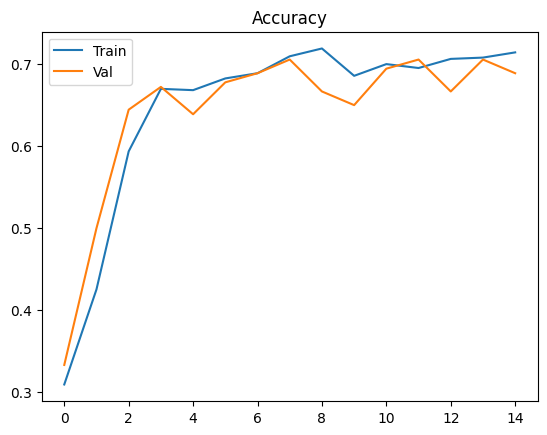

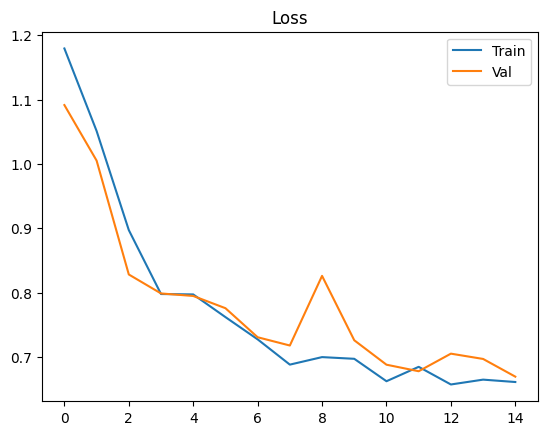

In [6]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=classes))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()


Fold 1/5
Found 720 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.3404 - loss: 1.2123 - val_accuracy: 0.6556 - val_loss: 0.9470
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5831 - loss: 0.9444 - val_accuracy: 0.6833 - val_loss: 0.8205
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6540 - loss: 0.8379 - val_accuracy: 0.6944 - val_loss: 0.7092
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6701 - loss: 0.7896 - val_accuracy: 0.6389 - val_loss: 0.7842
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6407 - loss: 0.8192 - val_accuracy: 0.7278 - val_loss: 0.6672
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6722 - loss: 0.7635 - val_accuracy: 0.7111 - val_loss: 0.6274
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6794 - loss: 0.7053 - val_accuracy: 0.7167 - val_loss: 0.6175
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7082 - loss: 0.7252 - val_accuracy: 0.7333 - val_loss:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.3805 - loss: 1.1574 - val_accuracy: 0.4889 - val_loss: 1.0090
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5483 - loss: 0.9502 - val_accuracy: 0.6667 - val_loss: 0.7843
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6318 - loss: 0.8404 - val_accuracy: 0.6833 - val_loss: 0.7946
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6808 - loss: 0.7267 - val_accuracy: 0.6833 - val_loss: 0.7402
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6936 - loss: 0.7251 - val_accuracy: 0.6611 - val_loss: 0.7500
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7292 - loss: 0.6738 - val_accuracy: 0.6556 - val_loss: 0.8487
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6759 - loss: 0.7249 - val_accuracy: 0.6556 - val_loss: 0.7987
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6695 - loss: 0.7103 - val_accuracy: 0.6278 - val_loss:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.3588 - loss: 1.2762 - val_accuracy: 0.3611 - val_loss: 1.0418
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5298 - loss: 0.9902 - val_accuracy: 0.6111 - val_loss: 0.8299
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5925 - loss: 0.8517 - val_accuracy: 0.6556 - val_loss: 0.7794
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6533 - loss: 0.8082 - val_accuracy: 0.6944 - val_loss: 0.6874
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6484 - loss: 0.8179 - val_accuracy: 0.6944 - val_loss: 0.7077
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6671 - loss: 0.7511 - val_accuracy: 0.6833 - val_loss: 0.6751
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6796 - loss: 0.7538 - val_accuracy: 0.7111 - val_loss: 0.6448
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6776 - loss: 0.7134 - val_accuracy: 0.6944 - val_loss:

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step
Fold 4/5
Found 720 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.3221 - loss: 1.2619 - val_accuracy: 0.4444 - val_loss: 1.0322
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.3942 - loss: 1.0850 - val_accuracy: 0.3333 - val_loss: 1.0388
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4301 - loss: 1.0284 - val_accuracy: 0.6833 - val_loss: 0.7220
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6572 - loss: 0.8072 - val_accuracy: 0.6333 - val_loss: 0.8160
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5693 - loss: 0.8852 - val_accuracy: 0.7222 - val_loss: 0.6821
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5902 - loss: 0.8019 - val_accuracy: 0.7056 - val_loss: 0.7014
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6888 - loss: 0.7523 - val_accuracy: 0.7722 - val_loss: 0.5757
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6887 - loss: 0.6885 - val_accuracy: 0.6778 - val_loss:

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 441ms/step
Fold 5/5
Found 720 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.3990 - loss: 1.1413 - val_accuracy: 0.4500 - val_loss: 1.0468
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5281 - loss: 0.9410 - val_accuracy: 0.5278 - val_loss: 0.9928
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6486 - loss: 0.8213 - val_accuracy: 0.6000 - val_loss: 0.8707
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6753 - loss: 0.7484 - val_accuracy: 0.5722 - val_loss: 0.9755
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6629 - loss: 0.8254 - val_accuracy: 0.6278 - val_loss: 0.9407
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7201 - loss: 0.6997 - val_accuracy: 0.6222 - val_loss: 0.8034
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6953 - loss: 0.6856 - val_accuracy: 0.6556 - val_loss: 0.8248
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6818 - loss: 0.6923 - val_accuracy: 0.6500 - val_loss:

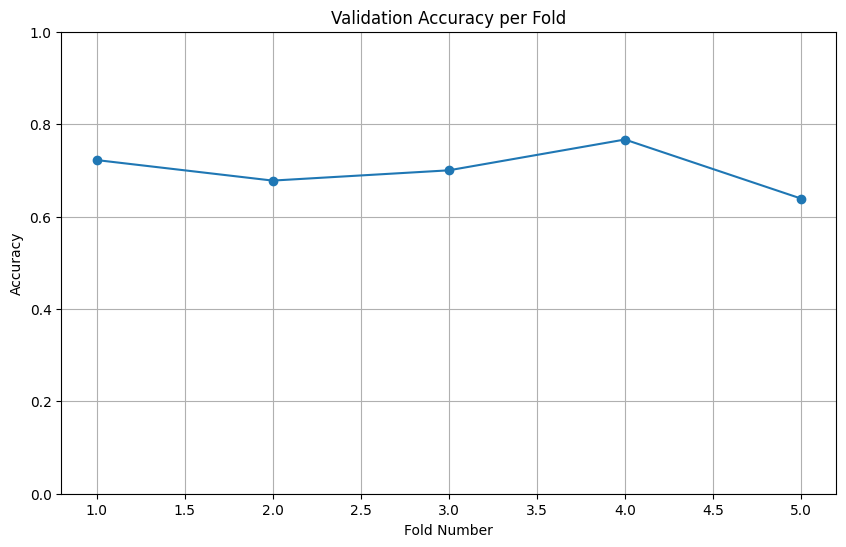

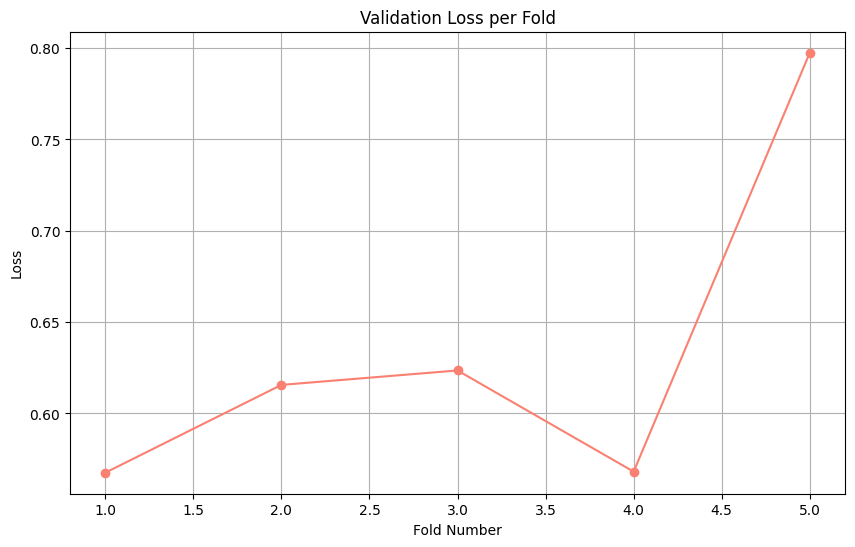


Training final model on the full dataset...
Found 900 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4043 - loss: 1.2427
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5401 - loss: 0.9486
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6137 - loss: 0.8640
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6988 - loss: 0.7374
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6851 - loss: 0.7133
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6999 - loss: 0.7088
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7269 - loss: 0.6484
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7144 - loss: 0.6231
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7406 - loss: 0.6337
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7608 - loss: 0.5242
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7634 - loss: 0.5335
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7684 - lo

In [12]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import shutil

# Fungsi untuk membuat dataset untuk k-fold cross-validation
def prepare_kfold_dataset(original_dir, target_dir, classes):
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)
    os.makedirs(target_dir)

    for cls in classes:
        os.makedirs(os.path.join(target_dir, cls), exist_ok=True)
        img_list = os.listdir(os.path.join(original_dir, cls))
        for img in img_list:
            src = os.path.join(original_dir, cls, img)
            dst = os.path.join(target_dir, cls, img)
            shutil.copy(src, dst)

# Persiapkan dataset untuk k-fold, gabungkan semua data kembali
kfold_data_dir = 'kfold_dataset'
prepare_kfold_dataset(original_dataset_dir, kfold_data_dir, classes)

# K-Fold Cross-Validation
n_splits = 5 # Jumlah lipatan (folds)
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Kumpulkan semua path gambar dan label
all_image_paths = []
all_labels = []
for i, cls in enumerate(classes):
    class_dir = os.path.join(kfold_data_dir, cls)
    image_list = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    all_image_paths.extend(image_list)
    all_labels.extend([i] * len(image_list))

all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

fold_accuracy = []
fold_loss = []
fold_classification_reports = []
fold_confusion_matrices = []

for fold, (train_index, val_index) in enumerate(kf.split(all_image_paths, all_labels)):
    print(f"Fold {fold+1}/{n_splits}")

    # Bagi data untuk fold saat ini
    train_paths, val_paths = all_image_paths[train_index], all_image_paths[val_index]
    train_labels, val_labels = all_labels[train_index], all_labels[val_index]

    # Hapus direktori train dan val sebelumnya
    if os.path.exists('temp_fold_dataset'):
      shutil.rmtree('temp_fold_dataset')
    os.makedirs('temp_fold_dataset/train', exist_ok=True)
    os.makedirs('temp_fold_dataset/val', exist_ok=True)

    # Buat struktur direktori sementara untuk generator
    for cls in classes:
        os.makedirs(os.path.join('temp_fold_dataset/train', cls), exist_ok=True)
        os.makedirs(os.path.join('temp_fold_dataset/val', cls), exist_ok=True)

    # Salin gambar ke direktori sementara
    for path, label in zip(train_paths, train_labels):
        class_name = classes[label]
        shutil.copy(path, os.path.join('temp_fold_dataset/train', class_name, os.path.basename(path)))

    for path, label in zip(val_paths, val_labels):
        class_name = classes[label]
        shutil.copy(path, os.path.join('temp_fold_dataset/val', class_name, os.path.basename(path)))


    # Persiapan Data Generator untuk fold saat ini
    train_generator = train_datagen.flow_from_directory(
        'temp_fold_dataset/train',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical'
    )

    val_generator = val_test_datagen.flow_from_directory(
        'temp_fold_dataset/val',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical',
        shuffle=False # Pastikan urutan tetap untuk evaluasi
    )

    # Bangun ulang model untuk setiap fold
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(classes), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Training model untuk fold saat ini
    history = model.fit(
        train_generator,
        epochs=15, # Sesuaikan jumlah epoch jika perlu
        validation_data=val_generator
    )

    # Evaluasi model pada data validasi fold saat ini
    loss, acc = model.evaluate(val_generator)
    print(f"Fold {fold+1} - Val Accuracy: {acc*100:.2f}%")
    print(f"Fold {fold+1} - Val Loss: {loss:.4f}")

    fold_accuracy.append(acc)
    fold_loss.append(loss)

    # Dapatkan prediksi untuk laporan klasifikasi dan matriks konfusi
    val_true = val_generator.classes
    val_pred = model.predict(val_generator)
    val_pred_classes = np.argmax(val_pred, axis=1)

    report = classification_report(val_true, val_pred_classes, target_names=classes, output_dict=True)
    matrix = confusion_matrix(val_true, val_pred_classes)

    fold_classification_reports.append(report)
    fold_confusion_matrices.append(matrix)

    # Opsional: Hapus direktori sementara untuk menghemat ruang
    shutil.rmtree('temp_fold_dataset')


# Hasil Cross-Validation
print("\nCross-Validation Results:")
print(f"Average Validation Accuracy: {np.mean(fold_accuracy)*100:.2f}% +/- {np.std(fold_accuracy)*100:.2f}%")
print(f"Average Validation Loss: {np.mean(fold_loss):.4f} +/- {np.std(fold_loss):.4f}")

# Anda dapat menganalisis laporan klasifikasi dan matriks konfusi dari setiap fold jika perlu
# Misalnya, rata-rata presisi, recall, f1-score per kelas di seluruh fold
average_classification_report = {}
for metric in ['precision', 'recall', 'f1-score']:
    average_classification_report[metric] = {}
    for cls in classes:
        # Kumpulkan nilai metrik untuk kelas ini dari semua fold
        metric_values = [report[cls][metric] for report in fold_classification_reports]
        # Hitung rata-rata
        average_classification_report[metric][cls] = np.mean(metric_values)

print("\nAverage Classification Report across Folds:")
for metric, values in average_classification_report.items():
    print(f"\n{metric.capitalize()}:")
    for cls, value in values.items():
        print(f"  {cls}: {value:.4f}")

# Matriks Konfusi rata-rata (ini kurang informatif dibandingkan rata-rata metrik, tapi bisa dihitung)
# average_confusion_matrix = np.mean(fold_confusion_matrices, axis=0)
# print("\nAverage Confusion Matrix across Folds:")
# print(average_confusion_matrix.astype(int))

# Visualisasi tidak langsung seperti sebelumnya karena ada banyak fold
# Anda bisa memvisualisasikan akurasi dan loss per fold jika diinginkan
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_splits + 1), fold_accuracy, marker='o')
plt.title('Validation Accuracy per Fold')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1) # Batasi sumbu y antara 0 dan 1
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_splits + 1), fold_loss, marker='o', color='salmon')
plt.title('Validation Loss per Fold')
plt.xlabel('Fold Number')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Setelah cross-validation selesai, Anda bisa melatih model terakhir
# pada seluruh dataset atau pada data training dari fold terbaik jika diperlukan.
# Untuk kesederhanaan, kita bisa melatih ulang pada seluruh data yang tersedia di kfold_data_dir
print("\nTraining final model on the full dataset...")

# Gunakan seluruh data untuk pelatihan akhir
full_datagen = ImageDataGenerator(rescale=1./255) # Biasanya tidak augmentasi pada data training akhir, atau gunakan yang minimal
full_generator = full_datagen.flow_from_directory(
    kfold_data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Bangun ulang model final
final_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Latih model final
final_history = final_model.fit(
    full_generator,
    epochs=20 # Sesuaikan jumlah epoch, mungkin sedikit lebih banyak dari per fold
)

print("\nFinal Model Trained on Full Dataset.")
# Anda bisa menyimpan final_model untuk penggunaan selanjutnya

# Catatan: Karena K-Fold menggunakan seluruh data untuk training/validasi di setiap fold,
# tidak ada 'test set' yang terpisah dalam skema K-Fold murni.
# Evaluasi performa dilakukan dengan merata-ratakan hasil validasi dari setiap fold.
# Jika Anda memerlukan evaluasi pada test set yang belum pernah dilihat sama sekali,
# Anda perlu memisahkan test set *sebelum* memulai K-Fold.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


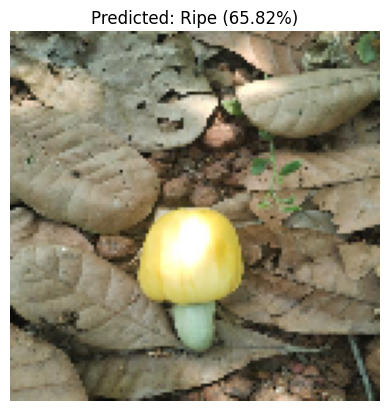

In [11]:

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Assuming 'model' is the trained model from the previous code
# Assuming 'classes' is the list of class names

def predict_new_image(model, img_path, target_size, classes):
    """
    Loads and preprocesses a single image, makes a prediction, and displays the result.

    Args:
        model: The trained Keras model.
        img_path: The path to the new image file.
        target_size: The target size for resizing the image (tuple of integers).
        classes: A list of class names in the correct order as predicted by the model.
    """
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
    img_array /= 255.0  # Rescale as done during training

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class = classes[predicted_class_index]
    confidence = predictions[0][predicted_class_index] * 100

    # Display image and prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

# Example Usage:
# Provide the path to your new image file
new_image_path = '/content/cashew-apple-fruit-maturity/Cashew Maturity Dataset/Ripe/IMG_20240229_114335132_jpg.rf.40dab1ec3456217ef653f0df4e0a830d.jpg' # Replace with the path to your image
target_size = (128, 128) # Should match the target_size used during training

predict_new_image(model, new_image_path, target_size, classes)